In [ ]:
import gdown

# Downloading the Kaggle Dataset.
file_ids = ["1m99RBSAG4zIPOJ2nfRupHj-jZDteTr6G", "1p-bKN89n-r-HnDGRmVF2tDpvHA5DUv0w", "1XDBeNesyWO9YKVxh5fGtzQM4V-YXL_ZJ","1hakH4A1exZu58b8AEakkJFNktCGjMoAH","1Tf03LIjkD3GsLHO_meTUocIhdZ-uZHbM","1eInNXFn5ibTRT6R5P5ntn5jw8G-sWoPA","1YZymTI35b22W8Z_X371xAIYUWz7SztLW"]  # Add all file IDs here
destinations=["assessments.csv","courses.csv","studentAssessment.csv","studentInfo.csv","studentRegistration.csv","studentVle.csv","vle.csv"]
for i, file_id in enumerate(file_ids, 0):
    destination = f"file_{i}.csv"
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, destinations[i], quiet=False)
    print(f"Downloaded: {destinations[i]}")

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ============================
# 1. Data Loading
# ============================
df_assessments = pd.read_csv("assessments.csv")
df_courses = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle = pd.read_csv("studentVle.csv")
df_vle = pd.read_csv("vle.csv")

# ============================
# 2. Merge studentAssessment & studentInfo
#    to get code_module & code_presentation
# ============================
# Note: A single student can appear in multiple modules/presentations.
# This merge will replicate rows if a student is in multiple modules.
# Adjust your data logic if needed for multi-module students.
df_studentAssessment_expanded = pd.merge(
    df_studentAssessment,
    df_studentInfo[["id_student", "code_module", "code_presentation"]],
    on="id_student",
    how="left"
)

# Now merge with assessments to get 'assessment_type'
df_studentAssessment_expanded = pd.merge(
    df_studentAssessment_expanded,
    df_assessments[["id_assessment", "assessment_type", "code_module", "code_presentation"]],
    on=["id_assessment", "code_module", "code_presentation"],
    how="left"
)

# ============================
# 3. Create 2 Assessment Features
#    (Avg_TMA_Score & Exam_Score)
# ============================
# Filter TMA vs. Exam
df_avg_tma = (
    df_studentAssessment_expanded[df_studentAssessment_expanded["assessment_type"] == "TMA"]
    .groupby(["id_student", "code_module", "code_presentation"])["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "Avg_TMA_Score"})
)

df_exam_score = (
    df_studentAssessment_expanded[df_studentAssessment_expanded["assessment_type"] == "Exam"]
    .groupby(["id_student", "code_module", "code_presentation"])["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "Exam_Score"})
)

# Merge TMA & Exam into a single assessment-features table
df_assess_feats = pd.merge(
    df_avg_tma,
    df_exam_score,
    on=["id_student", "code_module", "code_presentation"],
    how="outer"
).fillna(0)

# ============================
# 4. Create 40 VLE Features
#    (20 sum of clicks + 20 visits)
# ============================
# Merge studentVle with vle to get activity_type
df_studentVle_expanded = pd.merge(
    df_studentVle,
    df_vle[["id_site", "activity_type", "code_module", "code_presentation"]],
    on=["id_site", "code_module", "code_presentation"],
    how="left"
)

# (a) sum_clicks per (id_student, code_module, code_presentation, activity_type)
pivot_sum = (
    df_studentVle_expanded
    .groupby(["id_student", "code_module", "code_presentation", "activity_type"])["sum_click"]
    .sum()
    .unstack("activity_type", fill_value=0)
)
pivot_sum.columns = [f"sum_clicks_{col}" for col in pivot_sum.columns]
pivot_sum.reset_index(inplace=True)

# (b) number_of_visits per activity_type
#    define a "visit" as any row with sum_click > 0
df_studentVle_expanded["visit"] = df_studentVle_expanded["sum_click"].apply(lambda x: 1 if x > 0 else 0)
pivot_visits = (
    df_studentVle_expanded
    .groupby(["id_student", "code_module", "code_presentation", "activity_type"])["visit"]
    .sum()
    .unstack("activity_type", fill_value=0)
)
pivot_visits.columns = [f"visits_{col}" for col in pivot_visits.columns]
pivot_visits.reset_index(inplace=True)

# Merge sum_clicks & visits into one DF
df_vle_feats = pd.merge(
    pivot_sum, 
    pivot_visits, 
    on=["id_student", "code_module", "code_presentation"],
    how="outer"
).fillna(0)

# ============================
# 5. Merge Demographics + Assessments + VLE
# ============================
# We want 8 demographic columns from studentInfo:
#   1) gender
#   2) region
#   3) highest_education
#   4) imd_band
#   5) age_band
#   6) disability
#   7) studied_credits
#   8) num_of_prev_attempts
# Also keep final_result for target creation.

df_merged = pd.merge(
    df_studentInfo,
    df_assess_feats,    # (Avg_TMA_Score, Exam_Score)
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)

df_merged = pd.merge(
    df_merged,
    df_vle_feats,       # 40 VLE columns
    on=["id_student", "code_module", "code_presentation"],
    how="left"
).fillna(0)

# ============================
# 6. Remove Withdrawn & Create Binary Target
# ============================
df_merged = df_merged[df_merged["final_result"] != "Withdrawn"].copy()

df_merged["target"] = df_merged["final_result"].apply(
    lambda x: 1 if x in ["Pass", "Distinction"] else 0
)

# ============================
# 7. Select Final Columns (50 features + target)
# ============================
# 8 Demographic Features
demographic_cols = [
    "gender", "region", "highest_education", "imd_band",
    "age_band", "disability", "studied_credits", "num_of_prev_attempts"
]

# 2 Assessment Features
assessment_cols = ["Avg_TMA_Score", "Exam_Score"]

# 40 VLE Features = all pivot columns except the merge keys
all_vle_cols = set(df_vle_feats.columns) - {"id_student", "code_module", "code_presentation"}
vle_cols = list(all_vle_cols)  # convert set to list to preserve them

# Final feature list
feature_cols = demographic_cols + assessment_cols + vle_cols

# Keep IDs if you want them for reference
id_cols = ["id_student", "code_module", "code_presentation"]

# Build final DataFrame
df_final = df_merged[id_cols + feature_cols + ["target"]].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))
print("Number of features (excluding target):", len(feature_cols))

features = [col for col in df_final.columns]

print("Using the following feature columns:")
print(features)

features = [col for col in df_merged.columns]
print("Using the following feature columns for df_merged:")
print(features)

    id_student code_module code_presentation gender                region  \
0        11391         AAA             2013J      M   East Anglian Region   
1        28400         AAA             2013J      F              Scotland   
3        31604         AAA             2013J      F     South East Region   
4        32885         AAA             2013J      F  West Midlands Region   
5        38053         AAA             2013J      M                 Wales   
6        45462         AAA             2013J      M              Scotland   
7        45642         AAA             2013J      F  North Western Region   
8        52130         AAA             2013J      F   East Anglian Region   
9        53025         AAA             2013J      M          North Region   
10       57506         AAA             2013J      M          South Region   

              highest_education imd_band age_band disability  studied_credits  \
0              HE Qualification  90-100%     55<=          N           

In [2]:
import numpy as np

def clean_imd_band(x):
    """
    OULAD 'imd_band' might be one of:
        '0-10%', '10-20', '20-30%', '30-40%', '40-50%',
        '50-60%', '60-70%', '70-80%', '80-90%', '90-100%',
        or possibly NaN/unknown.
    One approach is to map each range to an integer 0..9 (ordinal encoding).
    Another approach is to take the midpoint of the range (e.g., '0-10%' -> 5).
    Below, we do simple ordinal encoding.
    """
    mapping = {
        '0-10%': 0, '10-20': 1, '20-30%': 2, '30-40%': 3, '40-50%': 4,
        '50-60%': 5, '60-70%': 6, '70-80%': 7, '80-90%': 8, '90-100%': 9
    }
    return mapping.get(x, np.nan)

def clean_age_band(x):
    """
    OULAD 'age_band' is often '0-35', '35-55', or '55<=',
    or possibly unknown/NaN.
    We'll do ordinal encoding here: 
        '0-35' -> 0, '35-55' -> 1, '55<=' -> 2
    """
    mapping = {
        '0-35': 0,
        '35-55': 1,
        '55<=': 2
    }
    return mapping.get(x, np.nan)

def clean_highest_education(x):
    """
    OULAD 'highest_education' can be:
        'No Formal quals', 'Lower Than A Level', 'A Level or Equivalent',
        'HE Qualification', 'Post Graduate Qualification'
    We can impose an ordinal hierarchy or just label-encode.
    Below is an example ordinal scheme:
    """
    mapping = {
        'No Formal quals': 0,
        'Lower Than A Level': 1,
        'A Level or Equivalent': 2,
        'HE Qualification': 3,
        'Post Graduate Qualification': 4
    }
    return mapping.get(x, np.nan)

def clean_disability(x):
    """
    OULAD 'disability' is typically 'Y' or 'N'.
    We'll do binary encoding:
        'Y' -> 1, 'N' -> 0
    """
    mapping = {'Y': 1, 'N': 0}
    return mapping.get(x, np.nan)

def clean_gender(x):
    """
    OULAD 'gender' is typically 'M' or 'F'.
    We'll do binary encoding:
        'M' -> 0, 'F' -> 1
    """
    mapping = {'M': 0, 'F': 1}
    return mapping.get(x, np.nan)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

# (Assume you've already merged your data into df_merged 
#  with the columns from studentInfo, studentAssessment, etc.)

# ------------------------
# 1. Apply known “column-specific” cleaning
# ------------------------
df_merged["imd_band"] = df_merged["imd_band"].apply(clean_imd_band)
df_merged["age_band"] = df_merged["age_band"].apply(clean_age_band)
df_merged["highest_education"] = df_merged["highest_education"].apply(clean_highest_education)
df_merged["disability"] = df_merged["disability"].apply(clean_disability)
df_merged["gender"] = df_merged["gender"].apply(clean_gender)

# 'region' is purely categorical. 
# We can either label-encode or one-hot encode. 
# For simplicity, let's label-encode it:
from sklearn.preprocessing import LabelEncoder
region_encoder = LabelEncoder()
df_merged["region"] = df_merged["region"].astype(str)
df_merged["region"] = region_encoder.fit_transform(df_merged["region"])

# If 'final_result' is still present, we'll keep it for now (to filter out withdrawn).
# numeric columns like 'studied_credits', 'num_of_prev_attempts', 'score', etc.
# should already be numeric. If not, we can force them:
numeric_cols = ["studied_credits", "num_of_prev_attempts", "Avg_TMA_Score", "Exam_Score"]
for col in numeric_cols:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce').fillna(0)

# Also for the pivoted VLE columns (sum_clicks_* and visits_*),
# ensure they are numeric:
vle_cols = [c for c in df_merged.columns if c.startswith("sum_clicks_") or c.startswith("visits_")]
for col in vle_cols:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce').fillna(0)

# ------------------------
# 2. Remove Withdrawn & create binary target
# ------------------------
df_merged = df_merged[df_merged["final_result"] != "Withdrawn"].copy()
df_merged["target"] = df_merged["final_result"].apply(
    lambda x: 1 if x in ["Pass", "Distinction"] else 0
)

# ------------------------
# 3. Select your final 50 features
# ------------------------
demographic_cols = [
    "gender", "region", "highest_education", "imd_band",
    "age_band", "disability", "studied_credits", "num_of_prev_attempts"
]
assessment_cols = ["Avg_TMA_Score", "Exam_Score"]
vle_cols = [c for c in df_merged.columns if c.startswith("sum_clicks_") or c.startswith("visits_")]
feature_cols = demographic_cols + assessment_cols + vle_cols

id_cols = ["id_student", "code_module", "code_presentation"]
df_final = df_merged[id_cols + feature_cols + ["target"]].copy()

print("df_final columns:", df_final.columns)
print("Number of features (excluding target):", len(feature_cols))

# ------------------------

df_final columns: Index(['id_student', 'code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'disability',
       'studied_credits', 'num_of_prev_attempts', 'Avg_TMA_Score',
       'Exam_Score', 'sum_clicks_dataplus', 'sum_clicks_dualpane',
       'sum_clicks_externalquiz', 'sum_clicks_folder', 'sum_clicks_forumng',
       'sum_clicks_glossary', 'sum_clicks_homepage', 'sum_clicks_htmlactivity',
       'sum_clicks_oucollaborate', 'sum_clicks_oucontent',
       'sum_clicks_ouelluminate', 'sum_clicks_ouwiki', 'sum_clicks_page',
       'sum_clicks_questionnaire', 'sum_clicks_quiz',
       'sum_clicks_repeatactivity', 'sum_clicks_resource',
       'sum_clicks_sharedsubpage', 'sum_clicks_subpage', 'sum_clicks_url',
       'visits_dataplus', 'visits_dualpane', 'visits_externalquiz',
       'visits_folder', 'visits_forumng', 'visits_glossary', 'visits_homepage',
       'visits_htmlactivity', 'visits_oucollaborate', 'visits_oucontent',
     

c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036

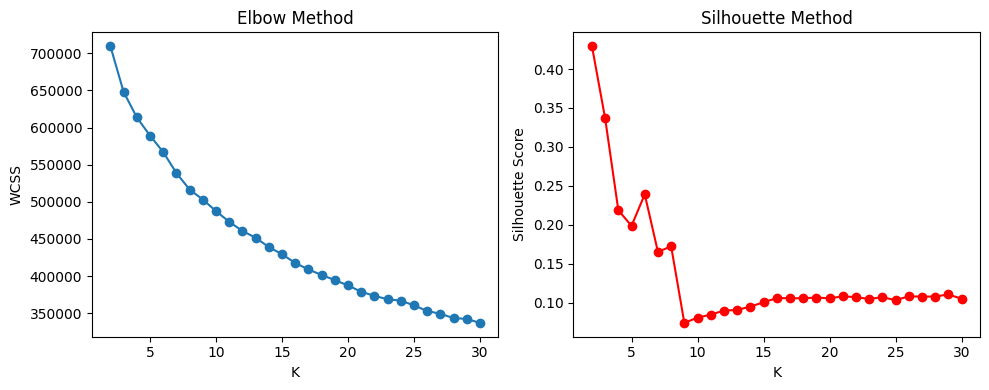

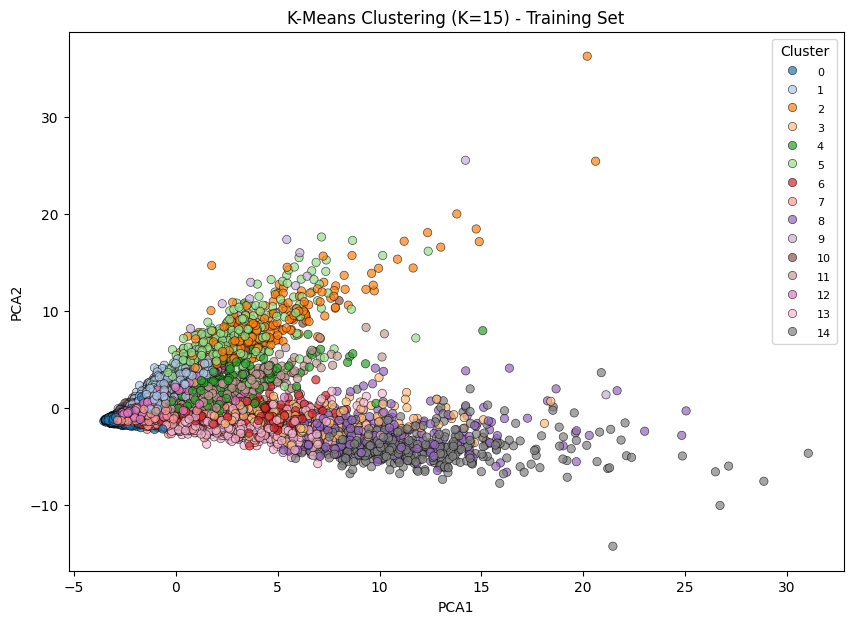

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# ===================================================
# 1) Load and Prepare the Data
# ===================================================
df = df_final.copy()  # df_final already has 50 features + 'target'
df.fillna(0, inplace=True)

# ---------------------------------------------------
# Split into train/test once, preserving 'target'
# ---------------------------------------------------
# We'll do this first so that each row of train_df/test_df 
# includes *all* columns, including 'target'.
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# ===================================================
# 2) KMeans on 50 Features (Exclude ID & Target)
# ===================================================
# We'll do the clustering steps *within* train_df/test_df,
# but ignoring the columns we don't want for unsupervised learning.

exclude_cols_for_clustering = ["id_student", "target"]  
use_cols = [c for c in df.columns if c not in exclude_cols_for_clustering]

# Create separate "feature-only" DataFrames for clustering
train_features = train_df[use_cols].copy()
test_features = test_df[use_cols].copy()

# ---------------------------------------------------
# Encode categorical columns within these feature sets
# ---------------------------------------------------
categorical_cols = [
    col for col in train_features.columns
    if train_features[col].dtype == 'object'
]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on train, transform both train/test
    train_features[col] = le.fit_transform(train_features[col].astype(str))
    test_features[col] = le.transform(test_features[col].astype(str))
    label_encoders[col] = le

# ---------------------------------------------------
# Standardize
# ---------------------------------------------------
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

# ---------------------------------------------------
# Determine K (Elbow & Silhouette on train only)
# ---------------------------------------------------
wcss = []
silhouette_scores = []
K_range = range(2, 31)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_temp.fit_predict(train_scaled)
    wcss.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(train_scaled, cluster_labels))

plt.figure(figsize=(10, 4))
# Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("K")
plt.ylabel("WCSS")
plt.title("Elbow Method")

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
#  Choose an optimal K from the plots
# ---------------------------------------------------
optimal_k = 15  # e.g., from your elbow/silhouette analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# ---------------------------------------------------
#  Fit on train_scaled, assign clusters
# ---------------------------------------------------
train_clusters = kmeans.fit_predict(train_scaled)
test_clusters = kmeans.predict(test_scaled)

# Attach cluster labels back to the main DataFrames
train_df["Cluster"] = train_clusters
test_df["Cluster"] = test_clusters

# ---------------------------------------------------
#  Optional: PCA for Visualization
# ---------------------------------------------------
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

train_df["PCA1"] = train_pca[:, 0]
train_df["PCA2"] = train_pca[:, 1]
test_df["PCA1"] = test_pca[:, 0]
test_df["PCA2"] = test_pca[:, 1]

# Visualize
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x=train_df['PCA1'], y=train_df['PCA2'],
    hue=train_df['Cluster'], palette="tab20",
    alpha=0.7, edgecolor="black"
)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title(f"K-Means Clustering (K={optimal_k}) - Training Set")
legend = scatter.legend_
for t in legend.texts:
    t.set_fontsize(8)
plt.show()


In [5]:
# ===================================================
# 3) Prepare for Modeling (Now We Have 'Cluster' + 'target')
# ===================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Make 'Cluster' categorical
train_df["Cluster"] = train_df["Cluster"].astype('category')
test_df["Cluster"] = test_df["Cluster"].astype('category')

# Choose whichever features you want for the classifier
# (Now 'target' is present in train_df/test_df)
exclude_for_model = ["id_student","PCA1","PCA2"]  
final_features = [col for col in train_df.columns if col not in exclude_for_model]

print("Using final features:", final_features)

# X/y split
X_train = train_df[final_features].drop(columns=["target"])
y_train = train_df["target"]
X_test = test_df[final_features].drop(columns=["target"])
y_test = test_df["target"]

# One-hot encode any categorical columns (including "Cluster")
categorical_cols_for_model = [
    c for c in X_train.columns
    if (train_df[c].dtype.name in ["object", "category"])
]
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols_for_model, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols_for_model, drop_first=True)

# Align
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Optionally create sample weights
if "code_module" in train_df.columns:
    mod_counts = train_df["code_module"].value_counts()
    train_df["module_weight"] = train_df["code_module"].map(lambda x: 1.0/mod_counts[x])
    sample_weights = train_df["module_weight"]
else:
    sample_weights = None

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion='entropy',
        max_depth=5,
        min_samples_leaf=4,
        min_samples_split=2,
        class_weight='balanced',
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        max_features=None,
        min_samples_leaf=4,
        min_samples_split=2,
        bootstrap=True,
        oob_score=True,
        class_weight='balanced',
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=3,
            min_samples_split=2,
            class_weight='balanced',
            random_state=42
        ),
        n_estimators=200,
        learning_rate=0.01,
        random_state=42
    )
}

print("\nFinal data prep complete. You have 'target' again plus a 'Cluster' feature.")
print("Models are defined and ready for training.")

Using final features: ['code_module', 'code_presentation', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'studied_credits', 'num_of_prev_attempts', 'Avg_TMA_Score', 'Exam_Score', 'sum_clicks_dataplus', 'sum_clicks_dualpane', 'sum_clicks_externalquiz', 'sum_clicks_folder', 'sum_clicks_forumng', 'sum_clicks_glossary', 'sum_clicks_homepage', 'sum_clicks_htmlactivity', 'sum_clicks_oucollaborate', 'sum_clicks_oucontent', 'sum_clicks_ouelluminate', 'sum_clicks_ouwiki', 'sum_clicks_page', 'sum_clicks_questionnaire', 'sum_clicks_quiz', 'sum_clicks_repeatactivity', 'sum_clicks_resource', 'sum_clicks_sharedsubpage', 'sum_clicks_subpage', 'sum_clicks_url', 'visits_dataplus', 'visits_dualpane', 'visits_externalquiz', 'visits_folder', 'visits_forumng', 'visits_glossary', 'visits_homepage', 'visits_htmlactivity', 'visits_oucollaborate', 'visits_oucontent', 'visits_ouelluminate', 'visits_ouwiki', 'visits_page', 'visits_questionnaire', 'visits_quiz', 'visits_repeatacti

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
)
from sklearn.base import clone

k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Prepare a dictionary to store metrics for each model
cv_results = {
    model_name: {'accuracy': [], 'balanced_accuracy': [], 'f1': [], 'auc': []}
    for model_name in models.keys()
}

# Perform cross-validation on the training data
for fold, (train_index, val_index) in enumerate(skf.split(X_train_encoded, y_train), start=1):
    X_cv_train = X_train_encoded.iloc[train_index]
    X_cv_val   = X_train_encoded.iloc[val_index]
    y_cv_train = y_train.iloc[train_index]
    y_cv_val   = y_train.iloc[val_index]
    
    # If you have sample weights
    w_cv_train = sample_weights.iloc[train_index]
    w_cv_val   = sample_weights.iloc[val_index]
    
    print(f"\n===== Cross-Validation Fold {fold} =====")
    
    for model_name, model in models.items():
        # Clone the model so that each fold starts fresh
        clf = clone(model)
        clf.fit(X_cv_train, y_cv_train, sample_weight=w_cv_train)
        
        y_cv_pred = clf.predict(X_cv_val)
        # Get probabilities for AUC calculation if the classifier supports it
        y_cv_proba = (
            clf.predict_proba(X_cv_val)[:, 1]
            if hasattr(clf, "predict_proba") else None
        )
        
        # Compute metrics
        acc  = accuracy_score(y_cv_val, y_cv_pred)
        bal_acc = balanced_accuracy_score(y_cv_val, y_cv_pred)
        f1   = f1_score(y_cv_val, y_cv_pred)
        auc  = (
            roc_auc_score(y_cv_val, y_cv_proba, sample_weight=w_cv_val)
            if y_cv_proba is not None else None
        )
        
        cv_results[model_name]['accuracy'].append(acc)
        cv_results[model_name]['balanced_accuracy'].append(bal_acc)
        cv_results[model_name]['f1'].append(f1)
        if auc is not None:
            cv_results[model_name]['auc'].append(auc)
        
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if auc is not None:
            print(f"AUC: {auc:.4f}")
        
print("\n===== Cross-Validation Summary =====")
for model_name in models.keys():
    avg_acc = np.mean(cv_results[model_name]['accuracy'])
    avg_bal_acc = np.mean(cv_results[model_name]['balanced_accuracy'])
    avg_f1 = np.mean(cv_results[model_name]['f1'])
    avg_auc = (
        np.mean(cv_results[model_name]['auc'])
        if cv_results[model_name]['auc'] else None
    )
    
    print(f"\n{model_name} Averages (k={k} folds):")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Balanced Accuracy: {avg_bal_acc:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    if avg_auc is not None:
        print(f"AUC: {avg_auc:.4f}")



===== Cross-Validation Fold 1 =====

Model: Decision Tree
Accuracy: 0.8663
Balanced Accuracy: 0.8350
F1 Score: 0.9040
AUC: 0.9204

Model: Random Forest
Accuracy: 0.8930
Balanced Accuracy: 0.8682
F1 Score: 0.9229
AUC: 0.9439

Model: AdaBoost
Accuracy: 0.8764
Balanced Accuracy: 0.8460
F1 Score: 0.9113
AUC: 0.9291

===== Cross-Validation Fold 2 =====

Model: Decision Tree
Accuracy: 0.8610
Balanced Accuracy: 0.8235
F1 Score: 0.9010
AUC: 0.9123

Model: Random Forest
Accuracy: 0.8770
Balanced Accuracy: 0.8555
F1 Score: 0.9104
AUC: 0.9398

Model: AdaBoost
Accuracy: 0.8610
Balanced Accuracy: 0.8266
F1 Score: 0.9005
AUC: 0.9241

===== Cross-Validation Fold 3 =====

Model: Decision Tree
Accuracy: 0.8574
Balanced Accuracy: 0.8331
F1 Score: 0.8961
AUC: 0.9163

Model: Random Forest
Accuracy: 0.8746
Balanced Accuracy: 0.8482
F1 Score: 0.9094
AUC: 0.9366

Model: AdaBoost
Accuracy: 0.8663
Balanced Accuracy: 0.8371
F1 Score: 0.9036
AUC: 0.9267

===== Cross-Validation Fold 4 =====

Model: Decision Tree

In [7]:
training_scores = {}

for model_name, model in models.items():
    # Clone the model so each training starts fresh
    clf = clone(model)
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights)
    
    y_train_pred = clf.predict(X_train_encoded)
    y_train_proba = clf.predict_proba(X_train_encoded)[:, 1]  # for AUC
    
    acc_train = accuracy_score(y_train, y_train_pred)
    bal_acc_train = balanced_accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_proba, sample_weight=sample_weights)
    
    training_scores[model_name] = {
        'accuracy': acc_train,
        'balanced_accuracy': bal_acc_train,
        'f1': f1_train,
        'auc': auc_train
    }

print("\n===== Training Performance on Entire Training Subset =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {training_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {training_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {training_scores[model_name]['f1']:.4f}")
    print(f"AUC: {training_scores[model_name]['auc']:.4f}")


===== Training Performance on Entire Training Subset =====

Decision Tree:
Accuracy: 0.8565
Balanced Accuracy: 0.8222
F1 Score: 0.8972
AUC: 0.9229

Random Forest:
Accuracy: 0.8838
Balanced Accuracy: 0.8611
F1 Score: 0.9157
AUC: 0.9424

AdaBoost:
Accuracy: 0.8662
Balanced Accuracy: 0.8368
F1 Score: 0.9035
AUC: 0.9287


In [8]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
    confusion_matrix
)
from sklearn.base import clone

validation_scores = {}

for model_name, model in models.items():
    # Refit each model on the entire training set
    clf = clone(model)
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights)
    
    y_val_pred = clf.predict(X_test_encoded)
    # For AUC, get predicted probabilities
    y_val_proba = clf.predict_proba(X_test_encoded)[:, 1]
    
    acc_val = accuracy_score(y_test, y_val_pred)
    bal_acc_val = balanced_accuracy_score(y_test, y_val_pred)
    f1_val = f1_score(y_test, y_val_pred)
    auc_val = roc_auc_score(y_test, y_val_proba)
    
    validation_scores[model_name] = {
        'accuracy': acc_val,
        'balanced_accuracy': bal_acc_val,
        'f1': f1_val,
        'auc': auc_val
    }

print("\n===== Final Holdout (Validation) Performance =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {validation_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {validation_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {validation_scores[model_name]['f1']:.4f}")
    print(f"AUC: {validation_scores[model_name]['auc']:.4f}")
    
    # Optionally, print the confusion matrix on the holdout set
    clf = clone(models[model_name])
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights)
    y_val_pred2 = clf.predict(X_test_encoded)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_val_pred2))



===== Final Holdout (Validation) Performance =====

Decision Tree:
Accuracy: 0.8633
Balanced Accuracy: 0.8264
F1 Score: 0.9032
AUC: 0.9204
Confusion Matrix:
[[1264  467]
 [ 300 3579]]

Random Forest:
Accuracy: 0.8859
Balanced Accuracy: 0.8623
F1 Score: 0.9180
AUC: 0.9413
Confusion Matrix:
[[1386  345]
 [ 295 3584]]

AdaBoost:
Accuracy: 0.8668
Balanced Accuracy: 0.8383
F1 Score: 0.9046
AUC: 0.9230
Confusion Matrix:
[[1322  409]
 [ 338 3541]]
